In [1]:
from IPython.display import Image

<font color='red'>
**Note:** This notebook is a work in progress and serves as a first proof of concept. Beware of bugs! 🐞
</font>

# Hello, Queneau?

Welcome to this exploration of literary style and the capabilities of large language models (LLMs) in understanding and recognizing it. Much of the existing literature on style transfer in AI focuses on the technical capabilities of these models. However, a critical aspect often overlooked is how well a language model truly "understands" (by lack of a better word) literary style (narratological concepts, rhetorical devices, linguistic play etc.). Can it discern and interpret stylistic nuances?

## Table of Contents

1. [_Exercices de Style_](#Exercises-de-Style-by-Raymond-Queneau)
2. [Inspecting the Data](#Exploring-the-Data)
3. [A closer look at two stories](#A-closer-look-at-two-stories)
4. [Experimental setup](#Experimental-setup)
5. [Running the experiments](#Running-the-experiments)
6. [Some initial results](#Some-initial-results)
   
   6.1. [Results by language/label space size](#Results-by-language/label-space-size)
   
   6.2. [Confusion between labels](#Confusion-between-labels)
   
   6.3. [Difficulties in distinguishing between labels](#Difficulties-in-distinguishing-between-labels)
7. [Further ideas (to be executed, or not)](#Further-ideas (to-be-executed,-or-not))
8. [References](#References)

## _Exercices de Style_ by Raymond Queneau

In this notebook, we will conduct several experiments centered around Raymond Queneau's _Exercices de Style_. First published in 1947, this collection presents the same basic narrative (fabula) rewritten in 99 unique 'styles', making it a perfect testbed for our exploration. We will refer to these 99 variations as 'exercices' throughout this notebook.

Some key points about this dataset:

- all stories are penned by Queneau, originally in French, as a form of stylistic practice, hence the title;
- the original collection includes 99 variations on a simple story about a man encountering another man on the bus, who irritates him;
- there are a couple of stories that are not part of the original 99, but we will focus on the core collection;
- the stories are short (100~300 words), allowing us to conduct numerous experiments efficiently without worrying (too much) about prompt or token restrictions common in LLMs;
- each story is titled in a way that reflects its style, though some titles are more straightforward than others: "sonnet", "alexandrines", "Cockney", "precision", "anagrams", etc.;
- the stories have been translated into over 35 languages (!), offering a unique opportunity to examine how LLMs perform across different languages;
- Barbara Wright -- the translator of the English version -- identifies 7 different groups of styles: types of speech, types of written prose, poetry styles, character sketches, experiments with grammar and rhetoric, jargon, and miscellaneous.

While exploring translations of the French original, we might wonder whether translators preserved the original stylistic features or actually introduced new styles, i.e. turning translations into adaptations (discussion to have!).

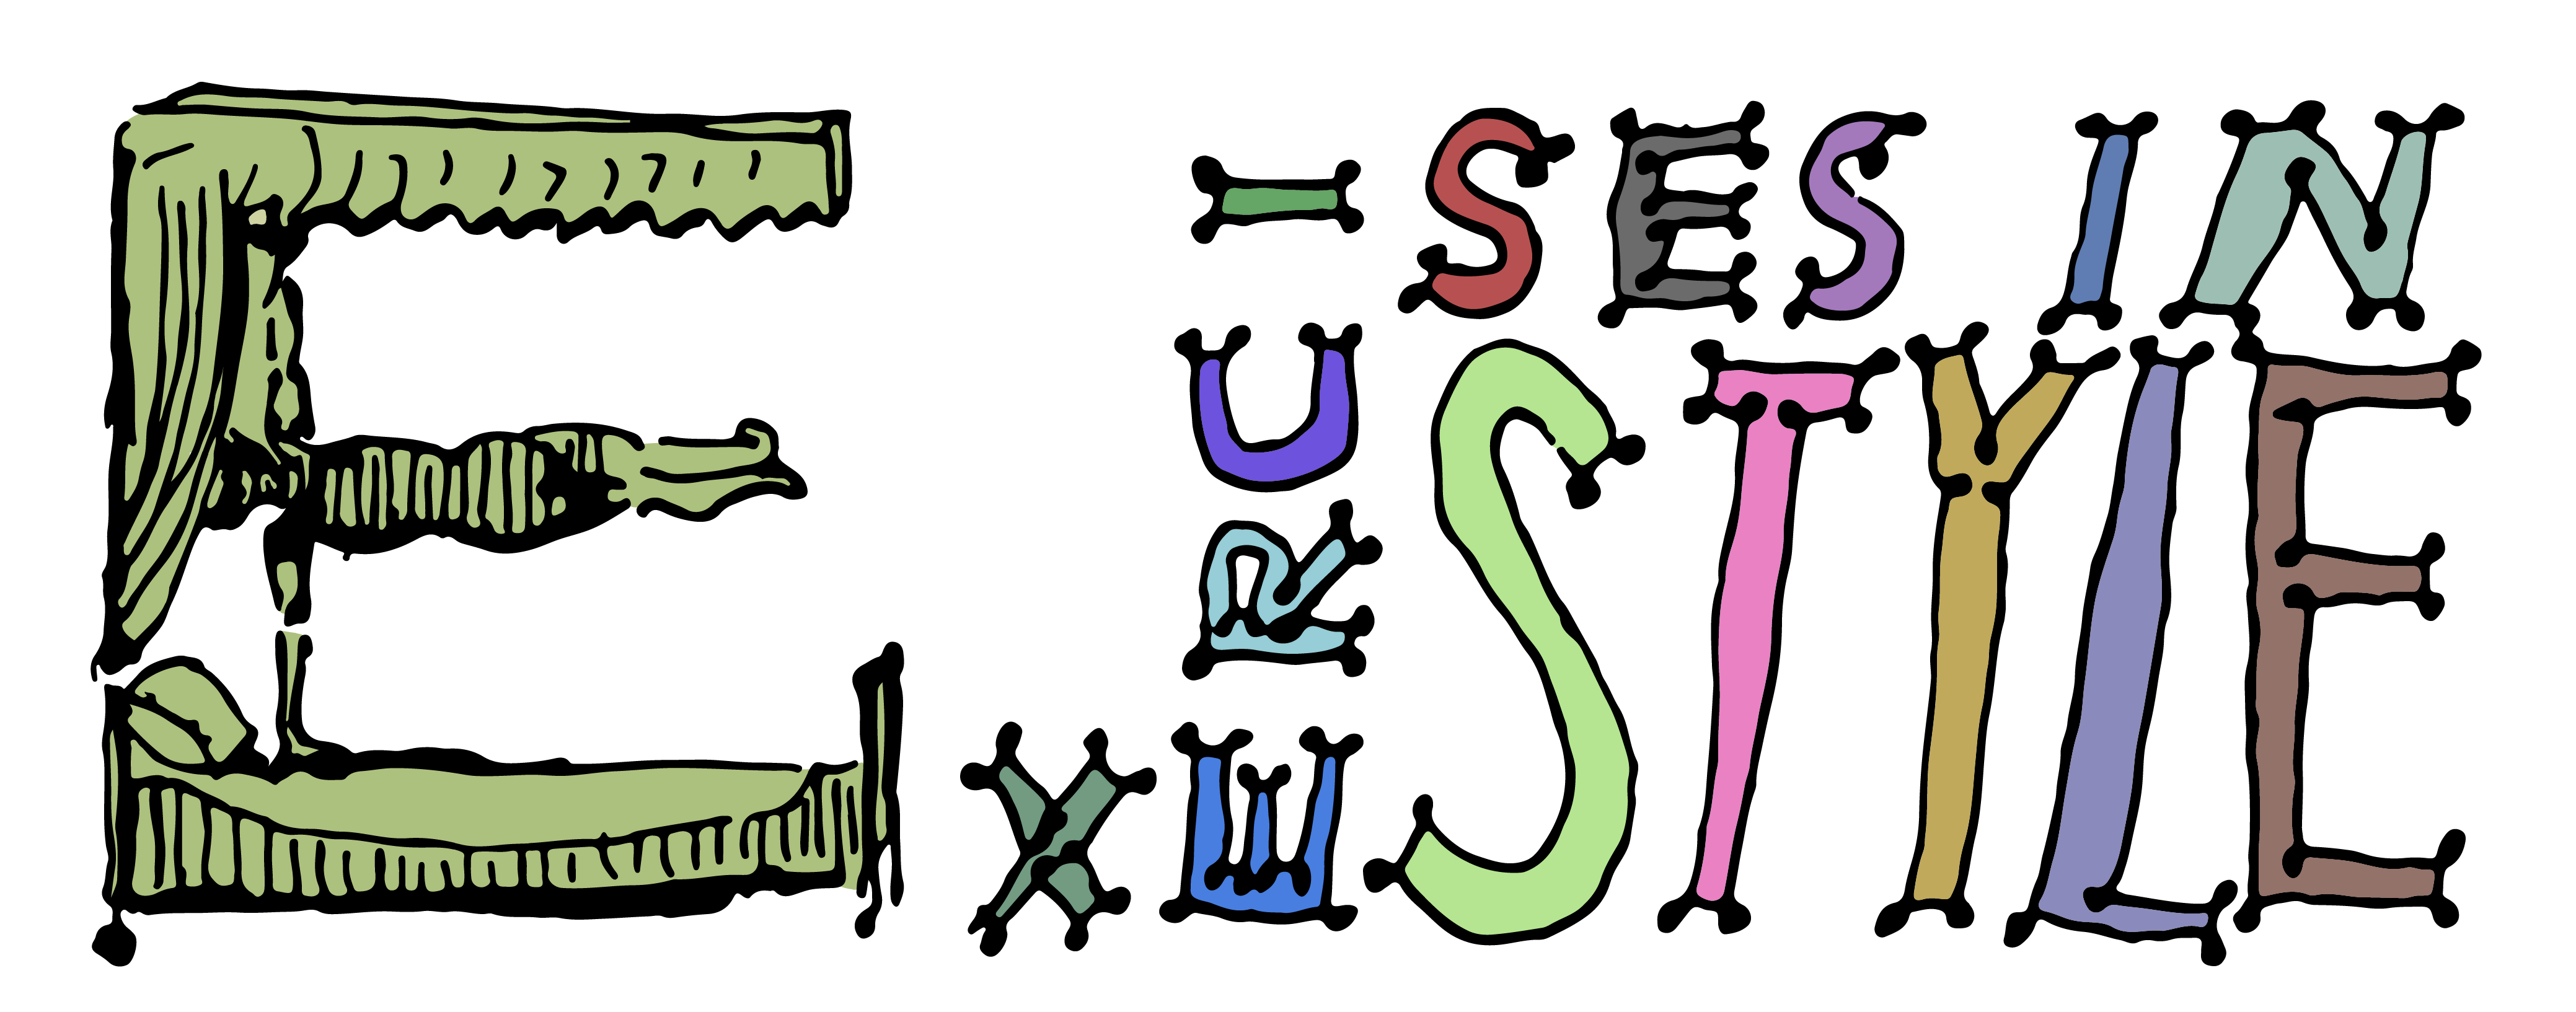

In [2]:
Image(filename='../img/ex_in_style-COLOR2.png', width="800")

_Stefan Themerson's cover for the 1958 edition of Raymond Queneau's "Exercises in Style". Vectorized and colorized by Wouter :-)_

## Inspecting the data

The dataset `.../data/stories_sample_24.xlsx` contains a sample of stories from Raymond Queneau's _Exercices de Style_, along with various labels and expert definitions. Below is an explanation of each column:

- **`id`**: a unique identifier assigned to each story, for easy referencing;
- **`auth`**: the original author of the story. Typically Raymond Queneau, unless the exercise was explicitely devised by someone else (e.g., a translator);
- **`transl`**: the name of the translator responsible for this version of the exercise, if applicable. This field is `NaN` when the story is in its original French version;
- **`lang`**: the language in which this version of the exercise is written (e.g., iso-codes, so `fre` for French, `eng` for English, etc.);
- **`pubdate`**: the year in which this version of the exercise was published;
- **`story`**: the complete text of the story as it appears in the relevant edition;
- **`label`**: the original title of the story, as it appears in the language-specific publication (e.g., "Métaphoriquement" in French, "Metaphorically" in English);
- **`universalLabel`**: original french label, used to map the same story across different languages;
- **`expertDefinition`**: a definition or interpretation provided by a scholar specific to this story by Queneau, detailing the stylistic device or narrative technique employed;
- **`sourceExpertDefinition`**: the source where the expert definition was found;
- **`universalLemma`**: a term that represents the rhetorical or stylistic device found/identified in the story, drawn from scholarly glossaries or handbooks;
- **`universalDefinition`**: the language-agnostic definition of the rhetorical, narrative, or stylistic device employed in this exercise;
- **`sourceUniversalDefinition`**: the reference source for the universal definition.

In [3]:
import pandas as pd

# load the CSV file
#df = pd.read_excel('../data/stories_sample_24.xlsx')
df = pd.read_excel('../data/stories_sample_24_EngFreItaGerSpaEpoUkrDut.xlsx')

# clean the 'label' column by stripping extra whitespace and removing quotes
df['label'] = df['label'].apply(lambda x: x.strip().replace("'", ""))

print(f"There are {len(df)} stories in the dataset")
df.head()

There are 240 stories in the dataset


,id,auth,transl,lang,pubdate,story,label,universalLabel,expertDefinition,sourceExpertDefinition,universalLemma,universalDefinition,sourceUniversalDefinition,notes
0,1,Raymond Queneau,NaN,fre,1947,"Dans l'S, à une heure d'affluence. Un type dan...",Notations,1. Notations,a linguistically minimal way of recording even...,"Bridgeman, 13 // Eco 2002, 226",absence of style // aschematiston,"a colour­less writing, freed from all bondage ...","Barthes 1967, 76-78 // Lanham 1991, 23",NaN
1,2,Raymond Queneau,NaN,fre,1947,"Vers le milieu de la journée et à midi, je me ...",En partie double,2. En partie double,Each element of the story is recounted in two ...,"Bridgeman, 14 // Eco 2002, 226",pleonasmus // synonymia // scesis onomaton,needless repetition. // amplification by synon...,"Lanham 1991, 191 // Lanham 1991, 191 // Lanham...",NaN
2,3,Raymond Queneau,NaN,fre,1947,Nous étions quelques-uns à nous déplacer de co...,Litotes,3. Litotes,[In this story the author] plays with alternat...,"Bridgeman, 51",litotes,a rhetorical figure or trope common in ordinar...,"Wales 2011, 265-266",NaN
3,4,Raymond Queneau,NaN,fre,1947,"Au centre du jour, jeté dans le tas des sardin...",Métaphoriquement,4. Métaphoriquement,"contenant à peine plus de mots, mais qui sont ...","Skutta, 237",metaphor,a very general label for different kinds of fi...,"Wales 2011, 254",NaN
4,5,Raymond Queneau,NaN,fre,1947,Tu devrais ajouter un bouton à ton pardessus l...,Rétrograde,5. Rétrograde,"[In this story,] events appear in the text in ...","Bridgeman, 20 // Eco 2002, 226",retrograde narration,set of events [is sorted] into reverse chronol...,"Montfort 2011, 216",NaN


In [4]:
# number of stories per language
stories_per_language = df['lang'].value_counts()

# language codes to full names
language_names = {
    'fre': 'French',
    'eng': 'English',
    'ger': 'German',
    'ita': 'Italian',
    'epo': 'Esperanto',
    'srp': 'Serbian',
    'spa': 'Spanish',
    'isl': 'Icelandic',
    'dut': 'Dutch',
    'ukr': 'Ukrainian'
}

# number of stories per language with full names
print("Number of stories per language code:")
for code, count in stories_per_language.items():
    print(f"{language_names[code]} ({code}): {count}")

Number of stories per language code:
French (fre): 24
English (eng): 24
German (ger): 24
Italian (ita): 24
Esperanto (epo): 24
Serbian (srp): 24
Spanish (spa): 24
Icelandic (isl): 24
Dutch (dut): 24
Ukrainian (ukr): 24


The code and output below gives us an ordered view of the **universal labels** of Raymond Queneau's _Exercices de Style_ and their corresponding **language-specific titles**.

e.g. for **Universal Label**, `1. Notations`, we get:

- **fre**: `Notations`
- **eng**: `Notation`
- **ita**: `Notazioni`
- **ger**: `Angaben`
- **ita**: `Notazioni`
- **epo**: `La bazo`
- **srp**: `Beleška`
- **spa**: `Notaciones`
- **isl**: `Minnispunktar`
- **dut**: `Notaties`
- **ukr**: `Нотатки`

In [5]:
import re

# extract the leading number from the universalLabel for sorting
def extract_number(label):
    match = re.match(r"(\d+)", label)
    return int(match.group(1)) if match else float('inf')

# pivot table that shows the label for each language under each universalLabel
pivot_table = df.pivot_table(
    index='universalLabel',
    columns='lang',
    values='label',
    aggfunc='first'  # if multiple entries exist, just take the first
).reset_index()

# sort pivot table by the extracted number from the universalLabel
pivot_table['sort_key'] = pivot_table['universalLabel'].apply(extract_number)
pivot_table = pivot_table.sort_values(by='sort_key').drop(columns='sort_key')

# languages you're interested in
languages_of_interest = ['fre', 'eng', 'ger', 'ita', 'epo', 'srp', 'spa', 'isl',  'dut', 'ukr']

# print universalLabel with corresponding labels in languages of interest
for _, row in pivot_table.iterrows():
    print(f"Universal Label: {row['universalLabel']}")
    
    for lang in languages_of_interest:
        print(f"{lang}: {row.get(lang, 'N/A')}")
    
    print("-" * 40)

Universal Label: 1. Notations
fre: Notations
eng: Notation
ger: Angaben
ita: Notazioni
epo: La bazo
srp: Beleška
spa: Notaciones
isl: Minnispunktar
dut: Notaties
ukr: Нотатки
----------------------------------------
Universal Label: 2. En partie double
fre: En partie double
eng: Double entry
ger: Verdopplung
ita: Partita doppia
epo: Pleonasma
srp: Dvostruko
spa: Por partida doble
isl: Í tvöföldum leik
dut: Dubbel op
ukr: З подвоєнням
----------------------------------------
Universal Label: 3. Litotes
fre: Litotes
eng: Litotes
ger: Litotes
ita: Litoti
epo: Litota
srp: Litote
spa: Lítotes
isl: Útdráttur
dut: Litotes
ukr: Лаконічно
----------------------------------------
Universal Label: 4. Métaphoriquement
fre: Métaphoriquement
eng: Metaphorically
ger: Metaphorisch
ita: Metaforicamente
epo: Metafora
srp: Metaforično
spa: Metafóricamente
isl: Á líkindamáli
dut: Figuurlijk
ukr: Метафорично
----------------------------------------
Universal Label: 5. Rétrograde
fre: Rétrograde
eng: Retrog

In [6]:
# dictionary mapping universalLabel to the language-specific labels
label_dict = {}
for _, row in pivot_table.iterrows():
    universal_label = row['universalLabel']
    label_dict[universal_label] = {lang: row.get(lang, 'N/A') for lang in languages_of_interest}
label_dict

{'1. Notations': {'fre': 'Notations',
  'eng': 'Notation',
  'ger': 'Angaben',
  'ita': 'Notazioni',
  'epo': 'La bazo',
  'srp': 'Beleška',
  'spa': 'Notaciones',
  'isl': 'Minnispunktar',
  'dut': 'Notaties',
  'ukr': 'Нотатки'},
 '2. En partie double': {'fre': 'En partie double',
  'eng': 'Double entry',
  'ger': 'Verdopplung',
  'ita': 'Partita doppia',
  'epo': 'Pleonasma',
  'srp': 'Dvostruko',
  'spa': 'Por partida doble',
  'isl': 'Í tvöföldum leik',
  'dut': 'Dubbel op',
  'ukr': 'З подвоєнням'},
 '3. Litotes': {'fre': 'Litotes',
  'eng': 'Litotes',
  'ger': 'Litotes',
  'ita': 'Litoti',
  'epo': 'Litota',
  'srp': 'Litote',
  'spa': 'Lítotes',
  'isl': 'Útdráttur',
  'dut': 'Litotes',
  'ukr': 'Лаконічно'},
 '4. Métaphoriquement': {'fre': 'Métaphoriquement',
  'eng': 'Metaphorically',
  'ger': 'Metaphorisch',
  'ita': 'Metaforicamente',
  'epo': 'Metafora',
  'srp': 'Metaforično',
  'spa': 'Metafóricamente',
  'isl': 'Á líkindamáli',
  'dut': 'Figuurlijk',
  'ukr': 'Метафорич

## A closer look at two stories

To better understand the dataset, let's examine the first two stories as they appear in the collection (and thus also in the excel file). These stories provide a clear demonstration of how Queneau manipulates simple narrative moments into distinct stylistic expressions.

#### Story 1: Notation

> ```plaintext
> In the S bus, in the rush hour. A chap of about 26, felt hat with a cord instead of a ribbon, neck too long, as if someone’s been having a tug-of-war with it. People getting off. The chap in question gets annoyed with one of the men standing next to him. He accuses him of jostling him every time anyone goes past. A snivelling tone which is meant to be aggressive. When he sees a vacant seat he throws himself on to it.
>
> Two hours later, I meet him in the Cour de Rome, in front of the gare Saint-Lazare. He’s with a friend who’s saying: “You ought to get an extra button put on your overcoat.” He shows him where (at the lapels) and why.
> ```

The title/label `notation` suggests a style marked by detailed, almost clinical observation, mirroring how one might jot down notes about a scene. The `expertDefinition` further clarifies this style as "a linguistically minimal way of recording events" (Bridgeman, 13) or "an example of *sermo manifestus*, in other words plain, explicit speech" (Eco 2002, 226). 

Next, the `universalLemma` and `universalDefinition` provide a broader context (ideally, language-agnostic!) for this story's style. E.g., Roland Barthe's notion of `Absence of Style` is deemed useful here: "A colourless writing, freed from all bondage to a pre-ordained state of language" (Barthes 1967, 76-78). The concept of `aschematiston` is also mentioned: "Without form; not employing figures of speech [...] plain style" (Lanham 1991, 23).

#### Story 2: Double Entry

> ```plaintext
> Towards the middle of the day and at midday I happened to be on and got on to the platform and the balcony at the back of an S-line and of a Contrescarpe-Champerrret bus and passenger transport vehicle which was packed and to all intents and purposes full. I saw and noticed a young man and an old adolescent who was rather ridiculous and pretty grotesque; thin neck and skinny windpipe, string and cord round his hat and tile. After a scrimmage and scuffle he says and states in a lachrymose and snivelling voice and tone that his neighbour and fellow-traveller is deliberately trying and doing his utmost to push him and obtrude himself on him every time anyone gets off and makes an exit. This having been declared and having spoken he rushes headlong and wends his way towards a vacant and a free place and seat.
>
> Two hours after and a-hundred-and-twenty minutes later, I meet him and see him again in the Cour de Rome and in front of the gare Saint-Lazare. He is with and in the company of a friend and pal who is advising and urging him to have a button and vegetable ivory disc added and sewn on to his overcoat and mantle.
> ```

It is not hard to see that this story is a variation of the first one. `Double Entry` cleverly plays with repetition and redundancy, reflecting the accounting principle of entering each transaction twice.

- **Expert Definition**:
   - "Each element of the story is recounted in two different ways, neither of which is particularly marked stylistically. Few of these pairs constitute exact synonyms, and the co-presence in this exercise of alternative tellings illustrates that choices between apparently almost interchangeable linguistic expressions affect the nature of a text" (Bridgeman, 14).
   - "An exercise on synonyms and paraphrase" (Eco 2002, 226).
   
- **Universal Lemmas and their definitions**: 
  - `pleonasmus`: "Needless repetition." (Lanham 1991, 191)
  - `synonymia`: "Amplification by synonym." (Lanham 1991, 191)
  - `scesis onomaton`: "Using a string of synonymous expressions." (Lanham 1991, 191)

## Experimental setup

Now, how would a language model perform in correctly linking the titles to the correct stories? In this first experiment, we evaluate how a SOTA language model performs in correctly linking story titles (labels) to their corresponding stories across multiple languages. Our dataset is controlled and aligned across languages, ensuring that the model faces the same label sets and story structures regardless of the language.

Our experiments will be structured as follows:

1. We randomly select $n$ labels/titles and their corresponding stories from the sample dataset. This process is performed in parallel across the  languages; i.e. we're making sure that the label sets and stories are aligned and controlled across French, English, Italian, etc.
   
2. Next, we present the model with one of these stories together with the set of labels it *must* choose from. In other words, the model will see one story at a time, and it will have to choose the correct label from the list of labels. For our example where the model has to choose between `Notation` and `Double Entry`, the prompts and possible outputs might look like this:

> ```plaintext
> Prompt #1: Please read the following story and assign the most appropriate label from these options: 'Notation', 'Double Entry'. Respond with only the label name. For example, if the correct label is 'Metaphorocally', reply 'Metaphorically'.
>
> {story-#1}
>
> Output: `Notation`
> ```

> ```plaintext
> Prompt #2: Please read the following story and assign the most appropriate label from these options: 'Notation', 'Double Entry'. Respond with only the label name. For example, if the correct label is 'Metaphorocally', reply 'Metaphorically'.
>
> {story-#2}
> 
> Output: `Double Entry`
> ```
 
1. For the same label space size, we execute the experiment multiple times with different randomly selected label-story pairs. We do this because some story-label pairs might be easier to predict than others. 
   - E.g. for each labels space size, we'll randomly select $20$ experiments (`num_experiments`, these are the randomly selected labels and their stories). 
   - Within each experiment, we will run a couple of iterations (`num_iterations`) to account for variance in the model's responses.
   
2. Finally, we will increase the label space size itself and repeat the process, evaluating the model's performance across different label configurations (same configuration per language, though!). E.g. we repeat the experiment 10 times for a label space of 3, 4, 5, ... etc.

3. The models responses will be recorded and written to a csv file (see `.../results/`). Each file will be named according to the language and label space size, for example: `results_eng/results_for_2_labels.csv`, `results_fre/results_for_3_labels.csv`, etc.

It's important to note that the model is presented with only one story at a time, along with a set of $n$ potential labels for that story. It does not have the ability to compare or reference any other stories during the decision-making process! This setup means that determining the correct label from a choice of two (where one is correct and the other incorrect) is significantly simpler than selecting the correct label from a much larger set, such as $8$ different options. Therefore, the task becomes increasingly challenging as the number of labels grows!

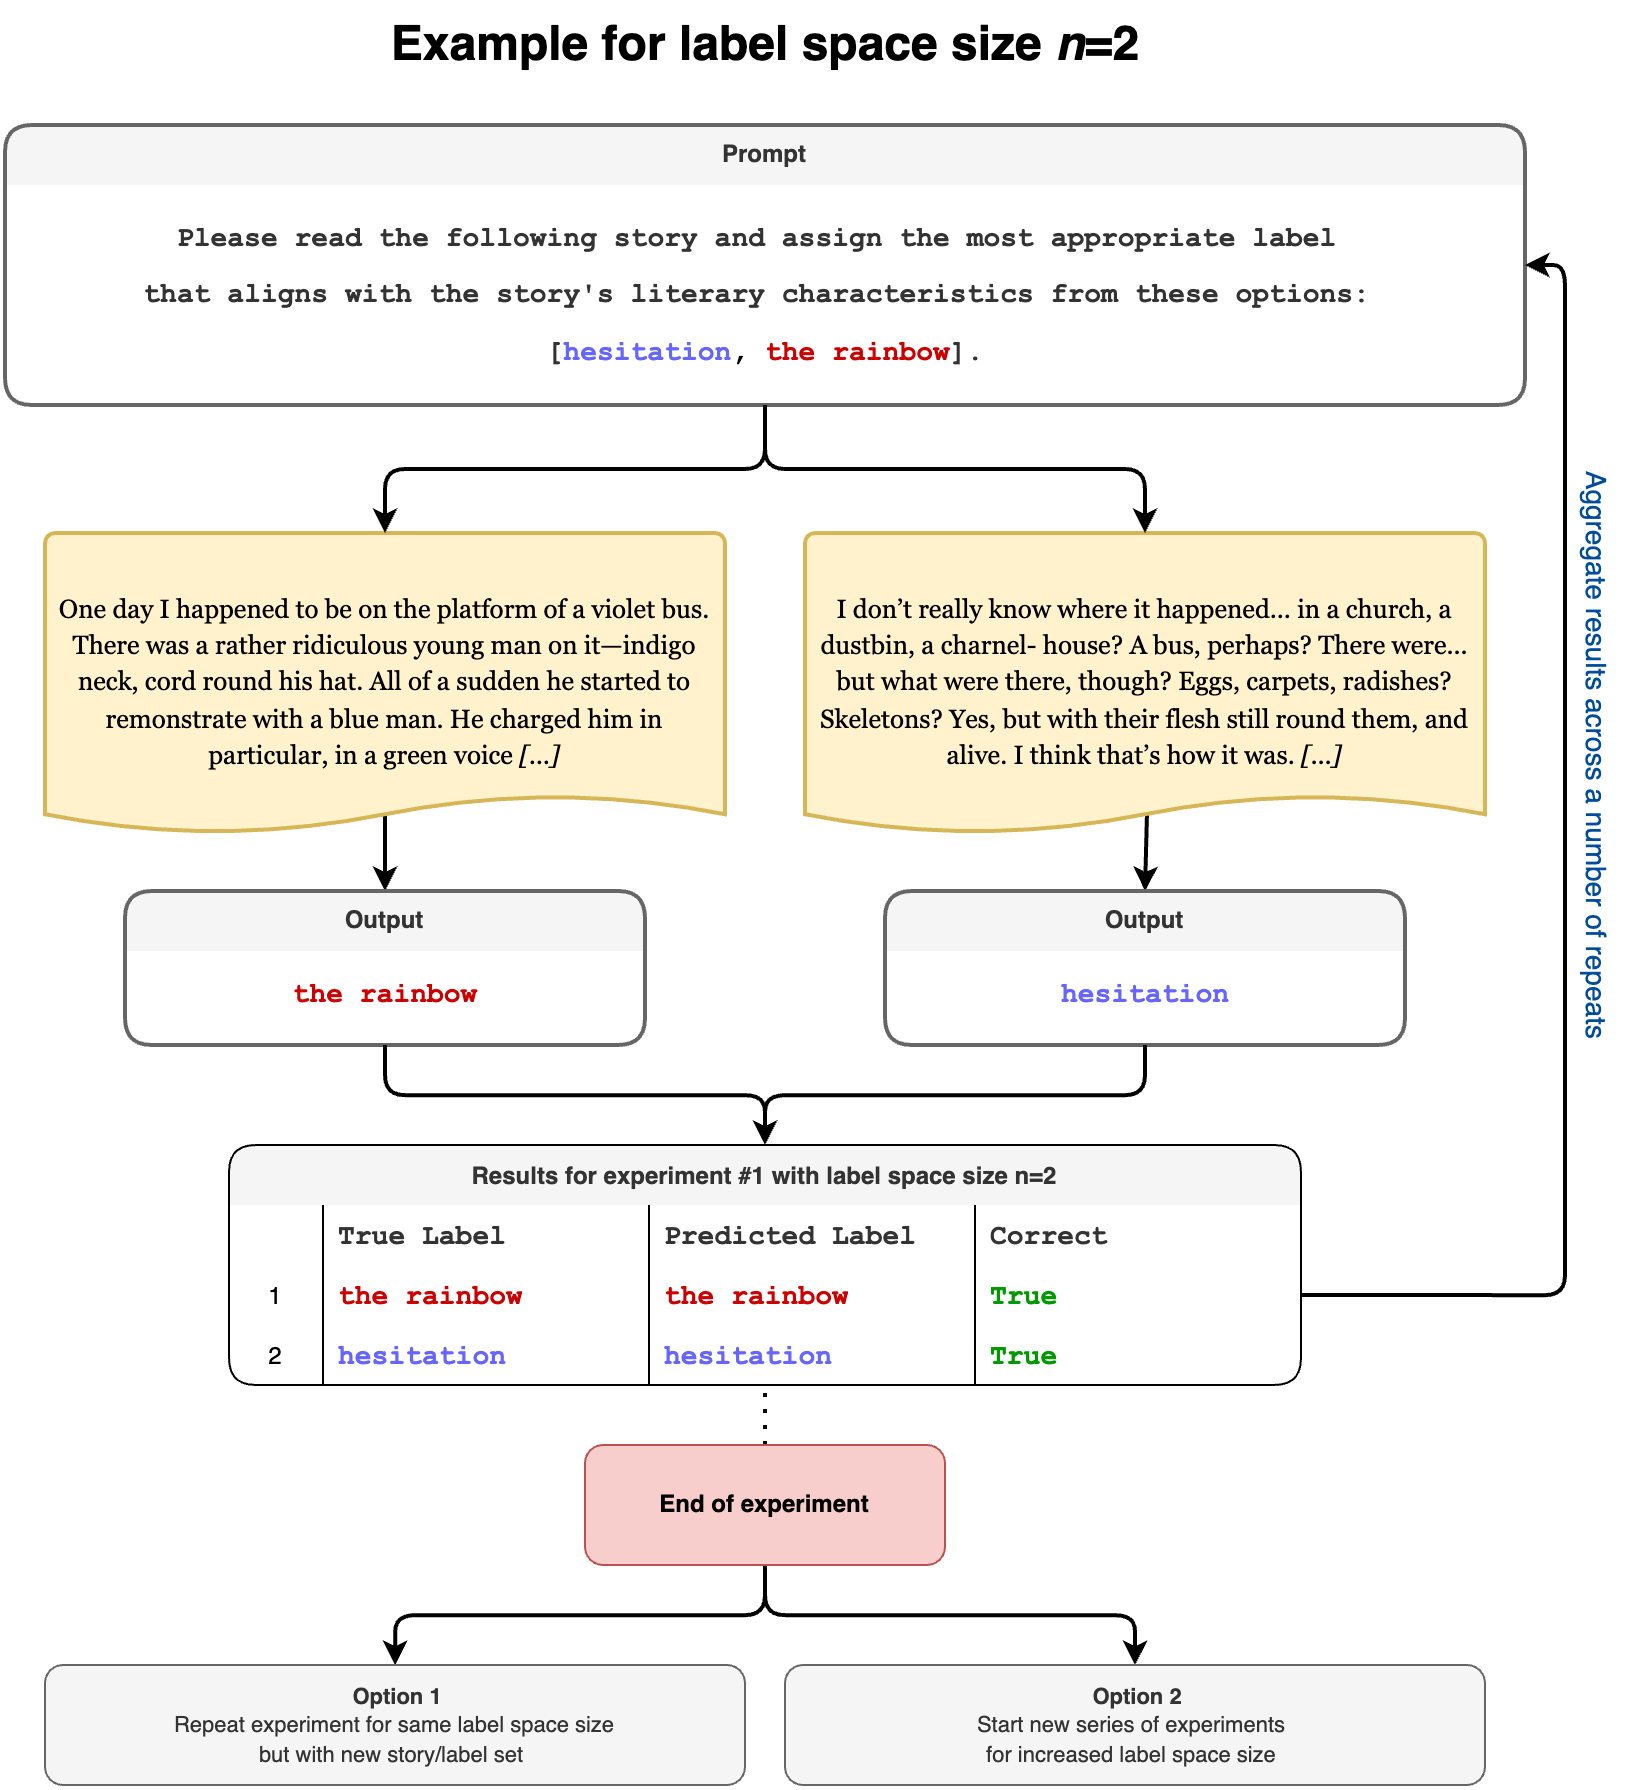

In [7]:
Image(filename="../img/helloqueneau_1.drawio.png", width="800")

In [8]:
# e.g., get the row with the label notation
df[df['label'] == 'Notation']

,id,auth,transl,lang,pubdate,story,label,universalLabel,expertDefinition,sourceExpertDefinition,universalLemma,universalDefinition,sourceUniversalDefinition,notes
24,1,Raymond Queneau,Barbara Wright,eng,1958,"In the S bus, in the rush hour. A chap of abou...",Notation,1. Notations,a linguistically minimal way of recording even...,"Bridgeman, 13 // Eco 2002, 226",absence of style // aschematiston,"a colour­less writing, freed from all bondage ...","Barthes 1967, 76-78 // Lanham 1991, 23",NaN


## Running the experiments
(with and without definitions attached)

In [9]:
import os
import random
import config
import openai
from openai import OpenAI

# first, we set the OpenAI API key and load the client
# the key is stored in config.py
openai.api_key = config.OPENAI_API_KEY
client = OpenAI(api_key=openai.api_key)

# we set some global parameters for all our experiments
#model = "gpt-4o-mini"  # the model
model = "gpt-3.5-turbo"  # the model
temperature = 0.1  # the temperature of the model
num_experiments = 20 # the number of experiments we want to run for a given label space size
num_iterations = 3  # the number of iterations for EACH experiment
min_num_labels = 2  # minimum number of labels we want to run the experiment with (i.e. min label space size)
max_num_labels = 10  # maximum number of labels we want to run the experiment with (i.e. max label space size)
verbose = True  # set to True if you want full output and logs
verbose_prompt = True  # set to True if you want to see the prompt

# set to True if you want to use definitions in the prompt!!!
use_definitions = True # can also be set later

# run experiments for these languages
languages_of_interest = ['fre', 'eng', 'ger', 'ita', 'epo', 'srp', 'spa', 'ukr', 'dut', 'isl']
# other langs: 'ita', 'epo', 'srp', 'spa', 'ukr', 'dut', 'isl'

In [10]:
# chore: quick calculation of the number of prompts that will be generated

In [11]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

def clean_label(label):
    return re.sub(r'^[\'"]+|[\'"]+$', '', label.strip()) # remove leading/trailing quotes (sometimes added by default in excel...)

# predict the label for a given story
def predict_label(story, labels, definitions):
    if use_definitions:
        label_definitions = "\n".join([f"{label}: {definitions[label]}" for label in labels])
        prompt = f"Please read the following story and assign the most appropriate label that aligns with the story's literary characteristics from these options: {labels}. Here are some helpful definitions of these labels that you can use:\n{label_definitions}\nRespond with only the label name."
    else:
        prompt = f"Please read the following story and assign the most appropriate label that aligns with the story's literary characteristics from these options: {labels}. Respond with only the label name."
    
    if verbose_prompt:
        print(f"\nPrompt: {prompt}")
        print(f"Story: {story[:50]}...")
    
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": story}
        ],
        model=model,
        max_tokens=60,
        temperature=temperature,
        top_p=1,
        n=1
    )
    predicted_label = clean_label(response.choices[0].message.content.strip())
    if verbose_prompt:
        print(f"Predicted Label: {predicted_label}\n")
    return predicted_label

# generate consistent labels for all experiments
def generate_consistent_labels(num_experiments, min_num_labels, max_num_labels, label_dict):
    selected_labels = []
    for _ in range(num_experiments):
        labels = []
        for i in range(min_num_labels, max_num_labels + 1):
            if labels:
                new_label = random.choice([label for label in label_dict if label not in labels])
                labels.append(labels[-1] + [new_label])
            else:
                labels.append(random.sample(list(label_dict.keys()), i))
        selected_labels.append(labels)
    return selected_labels

# run a single experiment
def run_experiment(df, num_labels, language_code, label_dict, selected_labels):
    all_results = []  # aggregate results across all experiments
    for exp in range(num_experiments):
        experiment_results = [] # results for the current experiment
        for iteration in range(num_iterations):
            results = []  # clear results for each experiment
            current_labels = selected_labels[exp][num_labels - min_num_labels]
            language_labels = [label_dict[label][language_code] for label in current_labels]
            definitions = {label: df[df['label'] == label]['expertDefinition'].values[0] for label in language_labels}
            available_stories = df[df['label'].isin(language_labels)]
            sample_size = min(num_labels, len(available_stories))
            selected_stories = available_stories.sample(n=sample_size, random_state=random.randint(1, 10000))
        
            if verbose:
                print(f"\nExperiment {exp + 1}, iteration {iteration + 1} with label space size {num_labels}:")
                print(f"Labels: {language_labels}\n")
        
            for idx, row in selected_stories.iterrows():
                predicted_label = predict_label(row['story'], language_labels, definitions)
                results.append({
                    'Experiment': exp + 1,
                    'Iteration': iteration + 1,
                    'Story Index': idx,
                    'True Label': row['label'],
                    'Predicted Label': predicted_label,
                    'Correct': row['label'] == clean_label(predicted_label),
                    'Label Space Size': len(language_labels),
                    'Language Code': language_code,
                    'Universal Label': row['universalLabel']
                })
            
            experiment_results.extend(results)
        
            if verbose:
                for result in results:
                    print(f"Story Index: {result['Story Index']}, True Label: {result['True Label']}, Predicted Label: {result['Predicted Label']}, Correct: {result['Correct']}")
                print("\n" + "="*25 + "\n")
            
        # accuracy for the current experiment
        correct_predictions = sum(result['Correct'] for result in experiment_results)
        accuracy = correct_predictions / len(experiment_results)
        print(f"{'*'*5} Accuracy for experiment {exp + 1} with {num_labels} labels, after {num_iterations} iterations: {accuracy:.2f} {'*'*5}\n")
        
        all_results.extend(experiment_results)
    
    return all_results

# run experiments for each language
def run_language_experiments(df, language_code, label_dict, selected_labels):
    print(f"\n\n=== Running experiments for language: {language_code} ===\n")
    language_df = df[df['lang'] == language_code]
    max_labels = min(max_num_labels, language_df['label'].nunique())
    all_results = []
    for i in range(min_num_labels, max_labels + 1):
        results = run_experiment(language_df, i, language_code, label_dict, selected_labels)
        all_results.extend(results)
        # total average accuracy for the label space size
        correct_predictions = sum(result['Correct'] for result in results)
        accuracy = correct_predictions / len(results)
        print(f"{'*'*5} Total average accuracy for a {language_code} label space with {i} labels, after {num_experiments} experiments with each {num_iterations} iterations: {accuracy:.2f} {'*'*5}\n")
        # save results differently based on whether we used definitions or not
        filename_suffix = "with_definitions" if use_definitions else "without_definitions"
        result_df = pd.DataFrame(results)
        result_df.to_csv(f'../results/results_{language_code}/results_for_{i}_labels_{filename_suffix}.csv', index=False)
    return all_results

selected_labels = generate_consistent_labels(num_experiments, min_num_labels, max_num_labels, label_dict)

In [ ]:
# now, we run all the experiments WITHOUT DEFINITIONS attached to the labels
use_definitions = False
print("Running experiments without definitions...")

all_results_without_definitions = []

# loop through languages (see code cell above) and run the experiments
for language in languages_of_interest:
    all_results_without_definitions.extend(run_language_experiments(df, language, label_dict, selected_labels))

combined_df_without_definitions = pd.DataFrame(all_results_without_definitions)

In [ ]:
# next, we run the (same!) experiments WITH DEFINITIONS attached to the labels
use_definitions = True

print("Running experiments with definitions...")

all_results_with_definitions = []

# loop through languages (see code above) and run the experiments
for language in languages_of_interest:
    all_results_with_definitions.extend(run_language_experiments(df, language, label_dict, selected_labels))

combined_df_with_definitions = pd.DataFrame(all_results_with_definitions)

## Some initial results

- Overall, a clear decline in accuracy as the label space size increases. This is not very surprising, given the increased complexity of the task: larger label spaces _are_ more challenging.
- Accuracies are very different across languages, even though the label-story spaces are (should be) perfectly aligned!
- Big contrast between results when definitions are provided and when they are not. I.e. the model is relying on the definitions to make its decision, rather than the story itself.

This result becomes visually more clear, when we aggregate results from _all experimental runs_ to assess the overall performance trend. Below, we calculate the mean accuracy and its standard error for each label space size, and use them for confidence interval plotting.

In [13]:
# uncomment if you want to save the dfs to excel!
#combined_df_with_definitions.to_excel('../results/combined_df_with_definitions.xlsx', index=False)
#combined_df_without_definitions.to_excel('../results/combined_df_without_definitions.xlsx', index=False)

# read the results from the saved excel files (instead of running the code above)
combined_df_with_definitions = pd.read_excel('../results/combined_df_with_definitions.xlsx')
combined_df_without_definitions = pd.read_excel('../results/combined_df_without_definitions.xlsx')

# inspect heads of the two dfs
print("shape of combined_df_with_definitions:", combined_df_with_definitions.shape)
print("shape of combined_df_without_definitions:", combined_df_without_definitions.shape)

print("\n")

print("Head of combined_df_with_definitions:")
display(combined_df_with_definitions.head(5))

print("Head of combined_df_without_definitions:")
display(combined_df_without_definitions.head(5))

shape of combined_df_with_definitions: (29490, 9)
shape of combined_df_without_definitions: (29490, 9)


Head of combined_df_with_definitions:


,Experiment,Iteration,Story Index,True Label,Predicted Label,Correct,Label Space Size,Language Code,Universal Label
0,1,1,3,Métaphoriquement,Métaphoriquement,True,2,fre,4. Métaphoriquement
1,1,1,20,Distinguo,Distinguo,True,2,fre,21. Distinguo
2,1,2,3,Métaphoriquement,Métaphoriquement,True,2,fre,4. Métaphoriquement
3,1,2,20,Distinguo,Distinguo,True,2,fre,21. Distinguo
4,1,3,3,Métaphoriquement,Métaphoriquement,True,2,fre,4. Métaphoriquement


Head of combined_df_without_definitions:


,Experiment,Iteration,Story Index,True Label,Predicted Label,Correct,Label Space Size,Language Code,Universal Label
0,1,1,3,Métaphoriquement,Métaphoriquement,True,2,fre,4. Métaphoriquement
1,1,1,20,Distinguo,Distinguo,True,2,fre,21. Distinguo
2,1,2,3,Métaphoriquement,Distinguo,False,2,fre,4. Métaphoriquement
3,1,2,20,Distinguo,Distinguo,True,2,fre,21. Distinguo
4,1,3,20,Distinguo,Distinguo,True,2,fre,21. Distinguo


### Results by language/label space size

Statistics for dut with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
0,dut,Dutch,2,0.82,0.03,0.76,0.88,0.72,0.82,0.76
1,dut,Dutch,3,0.66,0.03,0.60,0.73,0.53,0.66,0.57
2,dut,Dutch,4,0.66,0.03,0.60,0.72,0.54,0.66,0.57
3,dut,Dutch,5,0.60,0.03,0.55,0.65,0.48,0.60,0.51
4,dut,Dutch,6,0.61,0.02,0.57,0.66,0.49,0.61,0.52
5,dut,Dutch,7,0.54,0.03,0.49,0.59,0.43,0.54,0.46
6,dut,Dutch,8,0.53,0.02,0.49,0.57,0.40,0.53,0.44
7,dut,Dutch,9,0.52,0.02,0.48,0.55,0.39,0.52,0.42
8,dut,Dutch,10,0.51,0.02,0.48,0.54,0.38,0.51,0.42


Statistics for eng with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
9,eng,English,2,0.87,0.03,0.81,0.92,0.80,0.87,0.82
10,eng,English,3,0.75,0.03,0.69,0.81,0.65,0.75,0.68
11,eng,English,4,0.69,0.03,0.63,0.75,0.59,0.69,0.62
12,eng,English,5,0.64,0.03,0.59,0.69,0.54,0.64,0.56
13,eng,English,6,0.60,0.03,0.54,0.66,0.50,0.60,0.53
14,eng,English,7,0.57,0.03,0.52,0.62,0.46,0.57,0.49
15,eng,English,8,0.53,0.02,0.48,0.57,0.41,0.53,0.44
16,eng,English,9,0.50,0.02,0.46,0.54,0.38,0.50,0.41
17,eng,English,10,0.49,0.02,0.46,0.53,0.37,0.49,0.40


Statistics for epo with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
18,epo,Esperanto,2,0.78,0.04,0.71,0.86,0.70,0.78,0.73
19,epo,Esperanto,3,0.65,0.03,0.59,0.71,0.50,0.65,0.55
20,epo,Esperanto,4,0.61,0.03,0.55,0.67,0.48,0.61,0.52
21,epo,Esperanto,5,0.51,0.03,0.45,0.56,0.38,0.51,0.42
22,epo,Esperanto,6,0.46,0.02,0.43,0.50,0.34,0.46,0.37
23,epo,Esperanto,7,0.47,0.02,0.43,0.52,0.35,0.47,0.38
24,epo,Esperanto,8,0.45,0.02,0.42,0.48,0.33,0.45,0.36
25,epo,Esperanto,9,0.45,0.02,0.40,0.49,0.33,0.45,0.36
26,epo,Esperanto,10,0.45,0.02,0.41,0.49,0.34,0.45,0.37


Statistics for fre with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
27,fre,French,2,0.82,0.03,0.76,0.88,0.74,0.79,0.76
28,fre,French,3,0.65,0.03,0.60,0.71,0.51,0.64,0.55
29,fre,French,4,0.64,0.03,0.58,0.69,0.50,0.62,0.54
30,fre,French,5,0.56,0.03,0.51,0.61,0.41,0.54,0.45
31,fre,French,6,0.55,0.03,0.49,0.61,0.42,0.54,0.45
32,fre,French,7,0.52,0.03,0.47,0.57,0.38,0.50,0.42
33,fre,French,8,0.50,0.02,0.46,0.54,0.36,0.48,0.39
34,fre,French,9,0.45,0.02,0.41,0.48,0.30,0.44,0.34
35,fre,French,10,0.44,0.02,0.41,0.48,0.30,0.43,0.33


Statistics for ger with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
36,ger,German,2,0.81,0.03,0.75,0.87,0.71,0.81,0.74
37,ger,German,3,0.65,0.03,0.58,0.71,0.52,0.65,0.56
38,ger,German,4,0.63,0.03,0.57,0.68,0.50,0.63,0.54
39,ger,German,5,0.58,0.02,0.53,0.63,0.46,0.58,0.49
40,ger,German,6,0.56,0.03,0.50,0.62,0.45,0.56,0.48
41,ger,German,7,0.52,0.03,0.46,0.57,0.40,0.52,0.43
42,ger,German,8,0.53,0.02,0.48,0.57,0.42,0.53,0.45
43,ger,German,9,0.49,0.02,0.45,0.52,0.37,0.49,0.40
44,ger,German,10,0.50,0.02,0.46,0.54,0.37,0.50,0.41


Statistics for isl with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
45,isl,Icelandic,2,0.81,0.03,0.75,0.87,0.71,0.81,0.74
46,isl,Icelandic,3,0.60,0.03,0.54,0.67,0.45,0.60,0.50
47,isl,Icelandic,4,0.57,0.03,0.52,0.63,0.43,0.57,0.47
48,isl,Icelandic,5,0.42,0.02,0.37,0.46,0.27,0.42,0.31
49,isl,Icelandic,6,0.41,0.02,0.37,0.46,0.28,0.41,0.31
50,isl,Icelandic,7,0.40,0.02,0.36,0.44,0.27,0.40,0.30
51,isl,Icelandic,8,0.39,0.02,0.35,0.44,0.26,0.39,0.29
52,isl,Icelandic,9,0.38,0.02,0.34,0.43,0.27,0.38,0.30
53,isl,Icelandic,10,0.38,0.02,0.34,0.42,0.27,0.38,0.30


Statistics for ita with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
54,ita,Italian,2,0.88,0.03,0.82,0.93,0.81,0.88,0.83
55,ita,Italian,3,0.71,0.03,0.65,0.77,0.58,0.71,0.62
56,ita,Italian,4,0.72,0.03,0.67,0.77,0.61,0.72,0.64
57,ita,Italian,5,0.62,0.02,0.57,0.67,0.49,0.62,0.53
58,ita,Italian,6,0.60,0.02,0.57,0.64,0.47,0.60,0.50
59,ita,Italian,7,0.58,0.02,0.54,0.61,0.45,0.58,0.48
60,ita,Italian,8,0.57,0.02,0.53,0.60,0.43,0.57,0.47
61,ita,Italian,9,0.50,0.02,0.47,0.54,0.37,0.50,0.40
62,ita,Italian,10,0.48,0.01,0.45,0.51,0.35,0.48,0.38


Statistics for spa with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
63,spa,Spanish,2,0.88,0.03,0.82,0.93,0.82,0.87,0.83
64,spa,Spanish,3,0.69,0.02,0.65,0.74,0.55,0.68,0.59
65,spa,Spanish,4,0.75,0.02,0.71,0.80,0.65,0.75,0.68
66,spa,Spanish,5,0.61,0.03,0.55,0.66,0.48,0.60,0.52
67,spa,Spanish,6,0.57,0.03,0.51,0.62,0.44,0.57,0.48
68,spa,Spanish,7,0.53,0.03,0.48,0.58,0.40,0.52,0.44
69,spa,Spanish,8,0.51,0.02,0.47,0.54,0.37,0.50,0.41
70,spa,Spanish,9,0.47,0.02,0.43,0.50,0.34,0.46,0.37
71,spa,Spanish,10,0.45,0.02,0.41,0.49,0.32,0.44,0.35


Statistics for srp with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
72,srp,Serbian,2,0.86,0.03,0.80,0.92,0.79,0.86,0.81
73,srp,Serbian,3,0.74,0.03,0.68,0.80,0.63,0.74,0.66
74,srp,Serbian,4,0.74,0.03,0.70,0.79,0.64,0.74,0.67
75,srp,Serbian,5,0.64,0.02,0.60,0.68,0.52,0.64,0.55
76,srp,Serbian,6,0.57,0.02,0.53,0.61,0.44,0.57,0.48
77,srp,Serbian,7,0.56,0.02,0.52,0.60,0.43,0.56,0.47
78,srp,Serbian,8,0.53,0.02,0.49,0.57,0.41,0.53,0.44
79,srp,Serbian,9,0.47,0.02,0.43,0.50,0.34,0.47,0.37
80,srp,Serbian,10,0.46,0.01,0.43,0.48,0.33,0.46,0.36


Statistics for ukr with definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
81,ukr,Ukrainian,2,0.82,0.04,0.74,0.89,0.75,0.82,0.77
82,ukr,Ukrainian,3,0.71,0.03,0.64,0.77,0.59,0.71,0.62
83,ukr,Ukrainian,4,0.65,0.03,0.60,0.71,0.53,0.65,0.57
84,ukr,Ukrainian,5,0.57,0.02,0.53,0.62,0.44,0.57,0.48
85,ukr,Ukrainian,6,0.50,0.02,0.46,0.54,0.36,0.50,0.40
86,ukr,Ukrainian,7,0.49,0.02,0.45,0.53,0.36,0.49,0.40
87,ukr,Ukrainian,8,0.47,0.02,0.43,0.51,0.35,0.47,0.38
88,ukr,Ukrainian,9,0.46,0.02,0.43,0.50,0.35,0.46,0.38
89,ukr,Ukrainian,10,0.45,0.02,0.42,0.49,0.33,0.45,0.36


Statistics for dut without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
0,dut,Dutch,2,0.67,0.03,0.61,0.73,0.50,0.67,0.56
1,dut,Dutch,3,0.49,0.03,0.43,0.54,0.32,0.49,0.36
2,dut,Dutch,4,0.44,0.02,0.41,0.48,0.29,0.44,0.33
3,dut,Dutch,5,0.38,0.02,0.34,0.41,0.23,0.38,0.27
4,dut,Dutch,6,0.38,0.01,0.35,0.41,0.22,0.38,0.26
5,dut,Dutch,7,0.39,0.02,0.36,0.42,0.26,0.39,0.29
6,dut,Dutch,8,0.39,0.02,0.35,0.42,0.25,0.39,0.28
7,dut,Dutch,9,0.35,0.02,0.32,0.39,0.23,0.35,0.25
8,dut,Dutch,10,0.32,0.01,0.30,0.35,0.21,0.32,0.24


Statistics for eng without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
9,eng,English,2,0.76,0.03,0.69,0.82,0.64,0.76,0.68
10,eng,English,3,0.62,0.03,0.57,0.68,0.46,0.62,0.51
11,eng,English,4,0.57,0.02,0.53,0.62,0.42,0.57,0.47
12,eng,English,5,0.54,0.03,0.48,0.59,0.41,0.54,0.44
13,eng,English,6,0.47,0.02,0.42,0.52,0.34,0.47,0.37
14,eng,English,7,0.45,0.02,0.41,0.50,0.33,0.45,0.36
15,eng,English,8,0.44,0.02,0.41,0.48,0.33,0.44,0.36
16,eng,English,9,0.42,0.02,0.39,0.45,0.30,0.42,0.33
17,eng,English,10,0.42,0.02,0.38,0.45,0.30,0.42,0.33


Statistics for epo without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
18,epo,Esperanto,2,0.66,0.04,0.58,0.73,0.52,0.66,0.57
19,epo,Esperanto,3,0.52,0.03,0.47,0.58,0.36,0.52,0.41
20,epo,Esperanto,4,0.42,0.03,0.37,0.47,0.26,0.42,0.31
21,epo,Esperanto,5,0.37,0.03,0.31,0.43,0.24,0.37,0.27
22,epo,Esperanto,6,0.32,0.02,0.27,0.36,0.19,0.32,0.22
23,epo,Esperanto,7,0.36,0.02,0.31,0.41,0.25,0.36,0.28
24,epo,Esperanto,8,0.31,0.02,0.27,0.34,0.21,0.31,0.24
25,epo,Esperanto,9,0.29,0.02,0.24,0.33,0.19,0.29,0.21
26,epo,Esperanto,10,0.27,0.02,0.23,0.30,0.18,0.27,0.20


Statistics for fre without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
27,fre,French,2,0.71,0.04,0.64,0.78,0.59,0.69,0.62
28,fre,French,3,0.58,0.03,0.52,0.65,0.43,0.56,0.47
29,fre,French,4,0.42,0.02,0.38,0.47,0.25,0.42,0.29
30,fre,French,5,0.40,0.02,0.36,0.45,0.24,0.40,0.28
31,fre,French,6,0.43,0.03,0.38,0.48,0.29,0.43,0.33
32,fre,French,7,0.41,0.02,0.37,0.45,0.26,0.41,0.30
33,fre,French,8,0.40,0.02,0.37,0.44,0.26,0.40,0.30
34,fre,French,9,0.39,0.02,0.35,0.43,0.25,0.38,0.28
35,fre,French,10,0.35,0.02,0.31,0.38,0.22,0.35,0.25


Statistics for ger without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
36,ger,German,2,0.72,0.03,0.65,0.78,0.57,0.72,0.62
37,ger,German,3,0.68,0.03,0.62,0.73,0.53,0.68,0.58
38,ger,German,4,0.58,0.03,0.53,0.63,0.43,0.58,0.47
39,ger,German,5,0.51,0.02,0.46,0.56,0.37,0.51,0.40
40,ger,German,6,0.50,0.02,0.47,0.54,0.36,0.50,0.40
41,ger,German,7,0.45,0.02,0.41,0.49,0.31,0.45,0.35
42,ger,German,8,0.43,0.02,0.39,0.48,0.30,0.43,0.33
43,ger,German,9,0.39,0.02,0.35,0.43,0.26,0.39,0.29
44,ger,German,10,0.35,0.02,0.31,0.38,0.22,0.35,0.25


Statistics for isl without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
45,isl,Icelandic,2,0.60,0.03,0.55,0.65,0.40,0.60,0.47
46,isl,Icelandic,3,0.44,0.02,0.39,0.48,0.24,0.44,0.29
47,isl,Icelandic,4,0.38,0.02,0.34,0.42,0.20,0.38,0.24
48,isl,Icelandic,5,0.30,0.02,0.27,0.34,0.15,0.30,0.18
49,isl,Icelandic,6,0.29,0.02,0.25,0.32,0.14,0.29,0.17
50,isl,Icelandic,7,0.29,0.02,0.24,0.33,0.15,0.29,0.18
51,isl,Icelandic,8,0.26,0.02,0.22,0.29,0.14,0.26,0.17
52,isl,Icelandic,9,0.23,0.02,0.20,0.26,0.13,0.23,0.15
53,isl,Icelandic,10,0.25,0.01,0.22,0.28,0.14,0.25,0.16


Statistics for ita without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
54,ita,Italian,2,0.62,0.03,0.57,0.68,0.44,0.62,0.50
55,ita,Italian,3,0.49,0.04,0.41,0.57,0.36,0.49,0.39
56,ita,Italian,4,0.41,0.03,0.36,0.47,0.26,0.41,0.30
57,ita,Italian,5,0.31,0.02,0.28,0.35,0.16,0.31,0.20
58,ita,Italian,6,0.31,0.02,0.26,0.36,0.17,0.31,0.20
59,ita,Italian,7,0.30,0.02,0.25,0.34,0.17,0.30,0.20
60,ita,Italian,8,0.32,0.02,0.28,0.37,0.20,0.32,0.23
61,ita,Italian,9,0.31,0.02,0.27,0.35,0.19,0.30,0.22
62,ita,Italian,10,0.28,0.02,0.25,0.32,0.16,0.28,0.19


Statistics for spa without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
63,spa,Spanish,2,0.67,0.03,0.60,0.74,0.52,0.66,0.57
64,spa,Spanish,3,0.57,0.04,0.50,0.64,0.42,0.56,0.46
65,spa,Spanish,4,0.57,0.03,0.50,0.63,0.43,0.56,0.47
66,spa,Spanish,5,0.52,0.03,0.46,0.57,0.37,0.51,0.41
67,spa,Spanish,6,0.42,0.02,0.38,0.46,0.28,0.42,0.31
68,spa,Spanish,7,0.38,0.02,0.34,0.43,0.25,0.38,0.29
69,spa,Spanish,8,0.40,0.02,0.36,0.45,0.28,0.40,0.31
70,spa,Spanish,9,0.38,0.02,0.34,0.43,0.27,0.38,0.30
71,spa,Spanish,10,0.37,0.02,0.33,0.40,0.25,0.37,0.28


Statistics for srp without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
72,srp,Serbian,2,0.72,0.03,0.65,0.78,0.57,0.72,0.62
73,srp,Serbian,3,0.69,0.04,0.62,0.76,0.57,0.69,0.61
74,srp,Serbian,4,0.66,0.03,0.61,0.72,0.53,0.66,0.57
75,srp,Serbian,5,0.57,0.03,0.51,0.63,0.43,0.57,0.47
76,srp,Serbian,6,0.47,0.02,0.42,0.51,0.32,0.47,0.36
77,srp,Serbian,7,0.47,0.02,0.43,0.52,0.33,0.47,0.37
78,srp,Serbian,8,0.44,0.02,0.39,0.49,0.31,0.44,0.34
79,srp,Serbian,9,0.39,0.02,0.36,0.43,0.28,0.39,0.31
80,srp,Serbian,10,0.40,0.02,0.36,0.44,0.28,0.40,0.31


Statistics for ukr without definitions


,Language Code,Language Name,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
81,ukr,Ukrainian,2,0.68,0.04,0.60,0.77,0.58,0.68,0.61
82,ukr,Ukrainian,3,0.56,0.03,0.51,0.62,0.41,0.56,0.45
83,ukr,Ukrainian,4,0.58,0.03,0.52,0.63,0.43,0.58,0.47
84,ukr,Ukrainian,5,0.49,0.02,0.45,0.54,0.35,0.49,0.39
85,ukr,Ukrainian,6,0.44,0.02,0.40,0.49,0.30,0.44,0.34
86,ukr,Ukrainian,7,0.41,0.02,0.36,0.45,0.27,0.40,0.31
87,ukr,Ukrainian,8,0.38,0.02,0.34,0.42,0.26,0.38,0.29
88,ukr,Ukrainian,9,0.36,0.02,0.33,0.39,0.24,0.36,0.27
89,ukr,Ukrainian,10,0.37,0.02,0.33,0.40,0.25,0.37,0.28


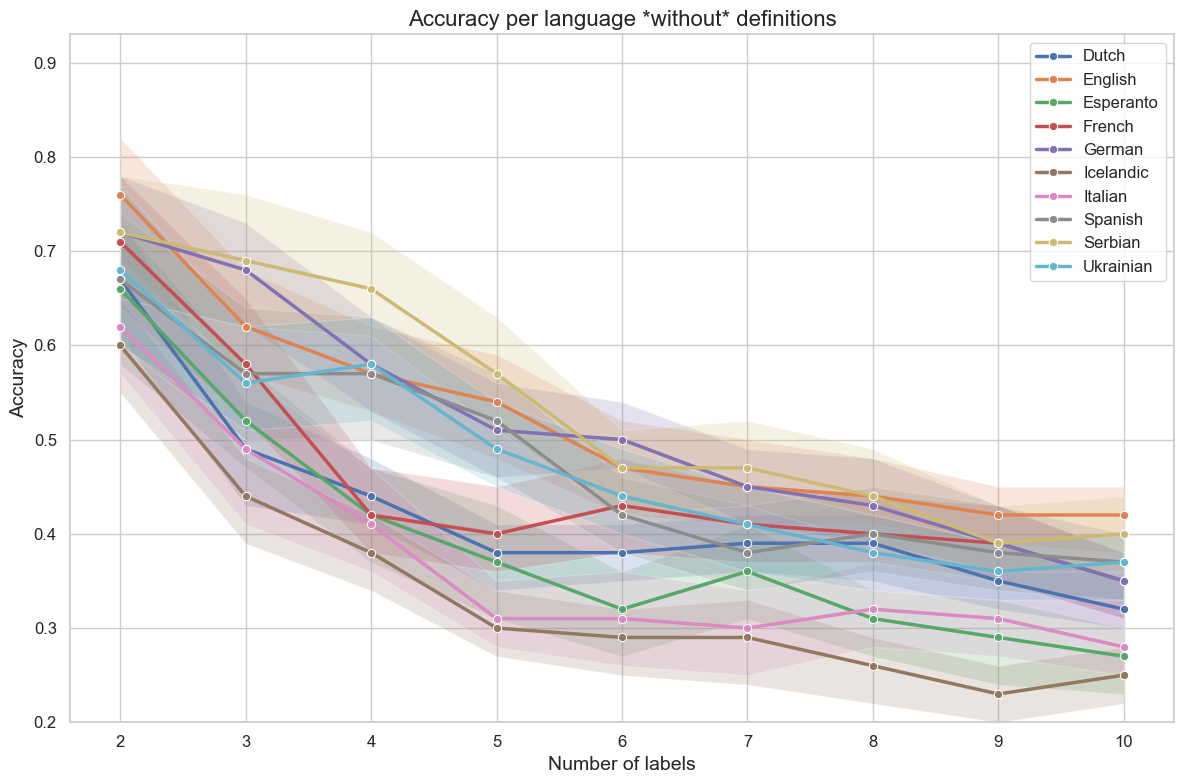

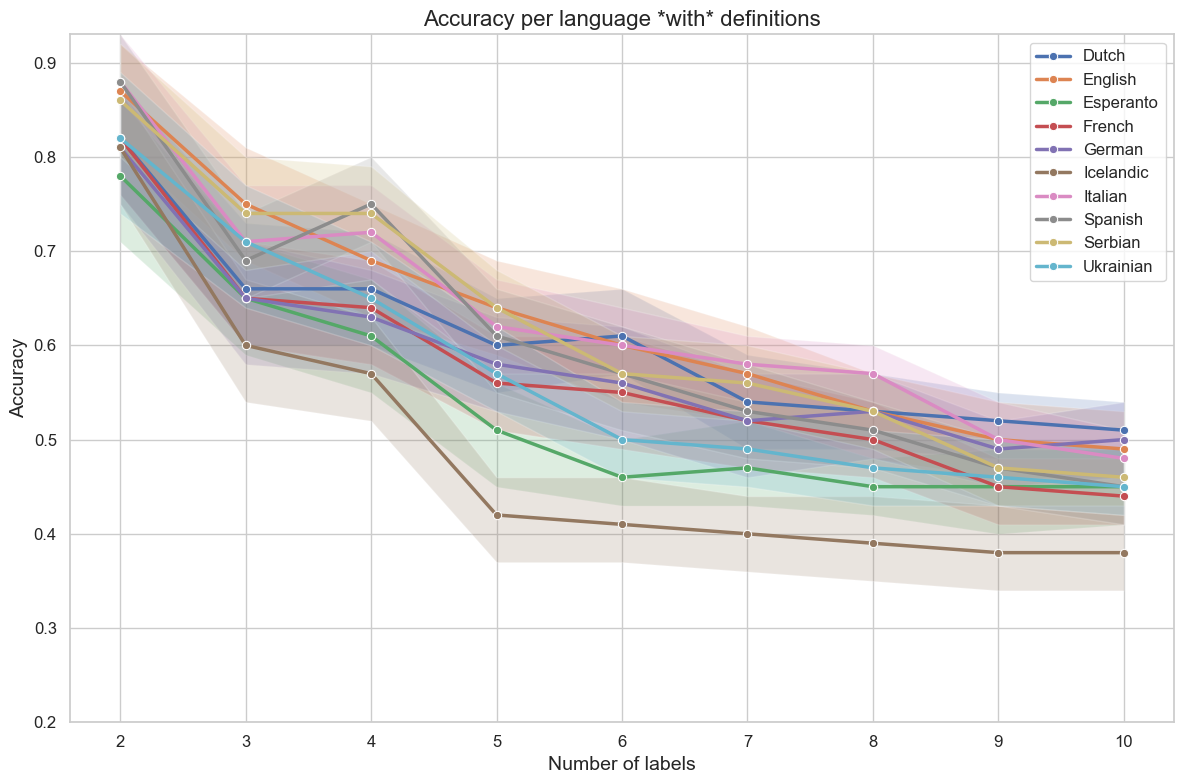

In [42]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

# calculate mean, standard error of the mean, and confidence intervals
def calculate_summary(df):
    # dict where we collect the results
    results = {
        'Language Code': [],
        'Language Name': [],
        'Label Space Size': [],
        'Mean Accuracy': [],
        'Accuracy SEM': [],
        'Lower CI Accuracy': [],
        'Upper CI Accuracy': [],
        'Mean Precision': [],
        'Mean Recall': [],
        'Mean F1 Score': []
    }

    # group the data by language code and label space size
    for (language_code, label_size), group in df.groupby(['Language Code', 'Label Space Size']):
        # calculate accuracy, precision, recall, f1 for each iteration
        iteration_accuracies = []
        iteration_precisions = []
        iteration_recalls = []
        iteration_f1_scores = []

        # group by experiment and iteration
        for (experiment, iteration), subgroup in group.groupby(['Experiment', 'Iteration']):
            y_true = subgroup['True Label'].tolist()
            y_pred = subgroup['Predicted Label'].tolist()

            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

            iteration_accuracies.append(accuracy)
            iteration_precisions.append(precision)
            iteration_recalls.append(recall)
            iteration_f1_scores.append(f1_score)

        # calculate mean and SEM for accuracy
        mean_accuracy = pd.Series(iteration_accuracies).mean()
        accuracy_sem = pd.Series(iteration_accuracies).sem()

        # aggregate data
        results['Language Code'].append(language_code)
        results['Language Name'].append(language_names[language_code])  # map code to lang name
        results['Label Space Size'].append(label_size)
        results['Mean Accuracy'].append(round(mean_accuracy, 2))
        results['Accuracy SEM'].append(round(accuracy_sem, 2))
        results['Lower CI Accuracy'].append(round(mean_accuracy - 1.96 * accuracy_sem, 2)) # for confidence bands in plot
        results['Upper CI Accuracy'].append(round(mean_accuracy + 1.96 * accuracy_sem, 2))
        results['Mean Precision'].append(round(pd.Series(iteration_precisions).mean(), 2))
        results['Mean Recall'].append(round(pd.Series(iteration_recalls).mean(), 2))
        results['Mean F1 Score'].append(round(pd.Series(iteration_f1_scores).mean(), 2))

    return pd.DataFrame(results)

def plot_results(summary_df, title, y_min, y_max, save_path):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(12, 8))

    # plot results for each language
    for language_name in summary_df['Language Name'].unique():
        language_summary = summary_df[summary_df['Language Name'] == language_name]
        sns.lineplot(data=language_summary,
                     x='Label Space Size',
                     y='Mean Accuracy',
                     marker='o',
                     label=f'{language_name}',
                     linewidth=2.5)
        
        plt.fill_between(language_summary['Label Space Size'], language_summary['Lower CI Accuracy'], language_summary['Upper CI Accuracy'], alpha=0.2)

    plt.title(title, fontsize=16)
    plt.xlabel('Number of labels', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(summary_df['Label Space Size'].unique(), fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# calculate summary statistics for each language
summary_stats_with_definitions = calculate_summary(combined_df_with_definitions)
summary_stats_without_definitions = calculate_summary(combined_df_without_definitions)

# now print them (separate dfs)
for language_code in summary_stats_with_definitions['Language Code'].unique():
    language_summary = summary_stats_with_definitions[summary_stats_with_definitions['Language Code'] == language_code]
    print(f"Statistics for {language_code} with definitions")
    display(language_summary)

for language_code in summary_stats_without_definitions['Language Code'].unique():
    language_summary = summary_stats_without_definitions[summary_stats_without_definitions['Language Code'] == language_code]
    print(f"Statistics for {language_code} without definitions")
    display(language_summary)

# calculating y-axis limits so that they are the same
y_min = min(summary_stats_with_definitions['Lower CI Accuracy'].min(), summary_stats_without_definitions['Lower CI Accuracy'].min())
y_max = max(summary_stats_with_definitions['Upper CI Accuracy'].max(), summary_stats_without_definitions['Upper CI Accuracy'].max())

# plot results with shared y-axis
plot_results(summary_stats_without_definitions, "Accuracy per language *without* definitions", y_min, y_max, "../results/charts/accuracy_without_definitions.png")
plot_results(summary_stats_with_definitions, "Accuracy per language *with* definitions", y_min, y_max, "../results/charts/accuracy_with_definitions.png")

Below, we create two heatmaps to visualize the mean accuracis for different languages across varying label space sizes (with and without definitions).

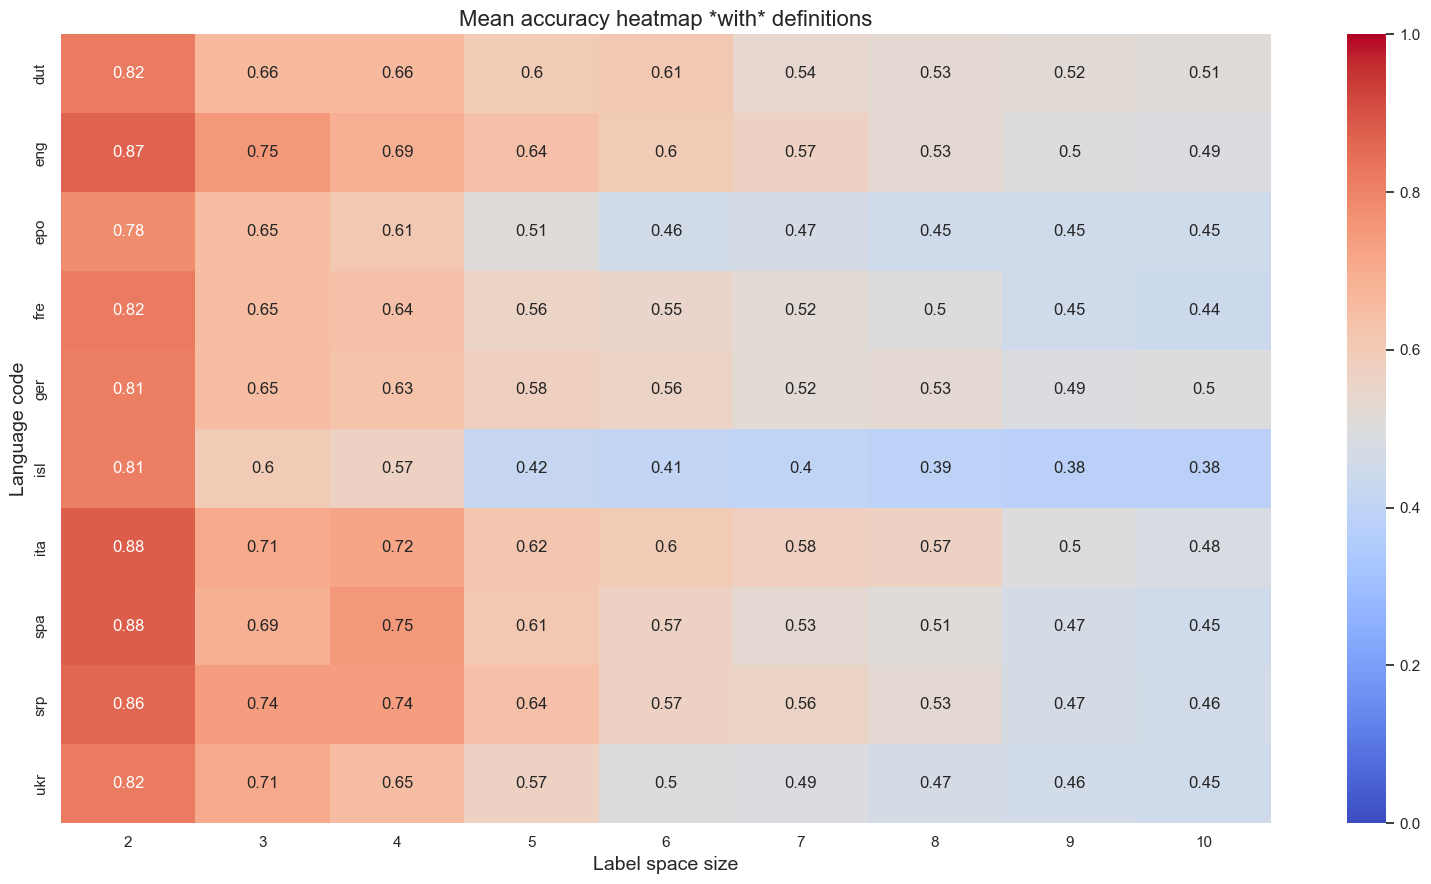

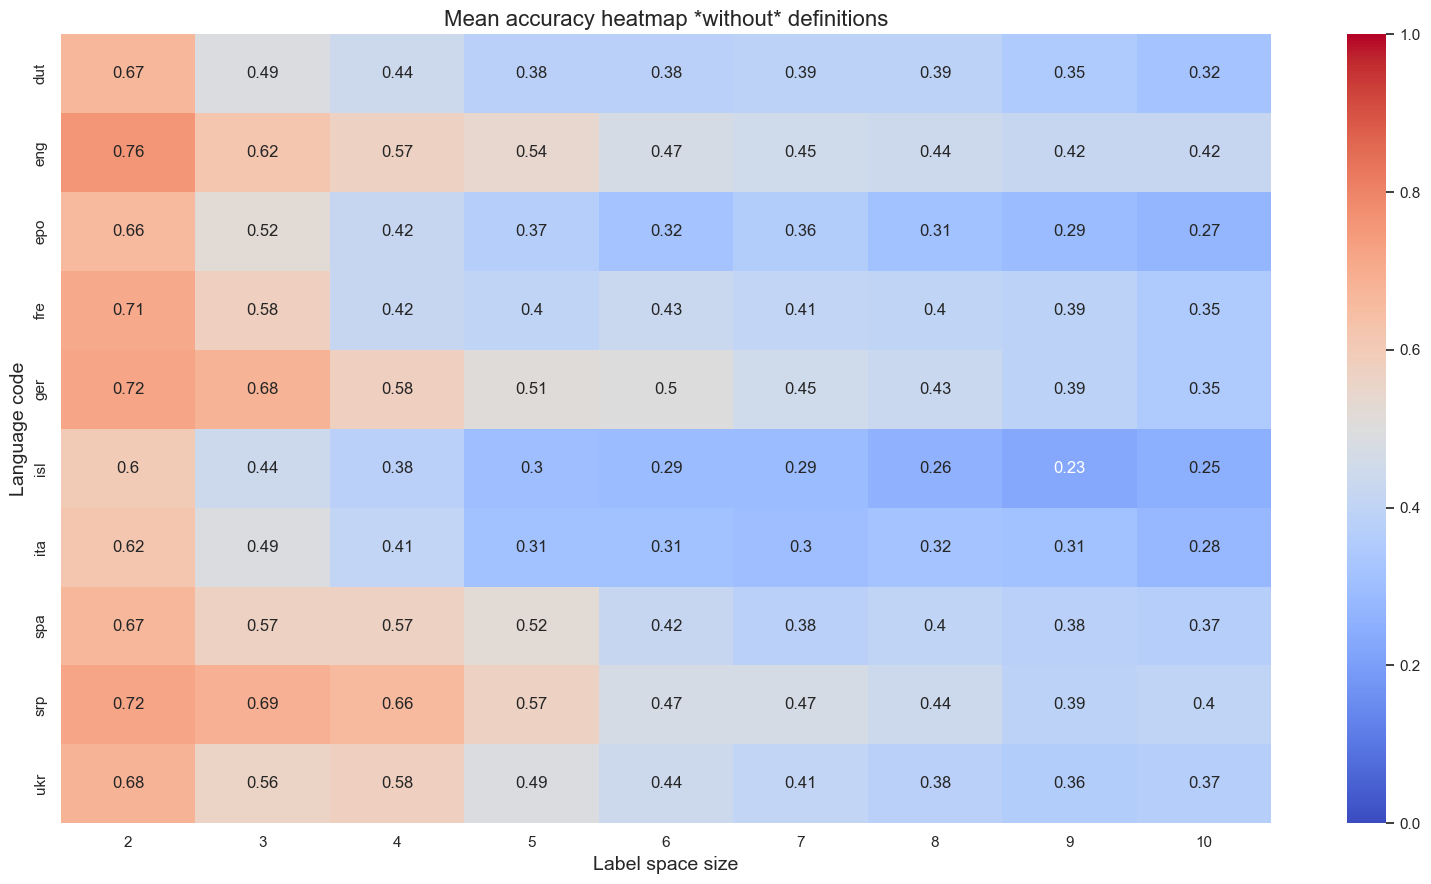

In [43]:
def plot_accuracy_heatmap(df, title):
    plt.figure(figsize=(16, 9))
    heatmap_data = df.pivot_table(values='Mean Accuracy', index='Language Code', columns='Label Space Size', aggfunc='mean')
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(title, fontsize=16)
    plt.xlabel('Label space size', fontsize=14)
    plt.ylabel('Language code', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"../results/charts/{title}.png", dpi=600)
    plt.show()

# heatmap of mean accuracies
plot_accuracy_heatmap(summary_stats_with_definitions, "Mean accuracy heatmap *with* definitions")
plot_accuracy_heatmap(summary_stats_without_definitions, "Mean accuracy heatmap *without* definitions")


### Confusion between labels

Now, how accurately does the model actually distinguish between different 'styles'? The confusion matrix below shows the frequency at which specific stories are misclassified as other stories.

In [62]:
import numpy as np
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import normalize
import plotly.io as pio

# building a confusion matrix
language_code = 'eng'  # for which language?
max_label_space_size = 6 # for which label space size?

df_filtered = combined_df_with_definitions[(combined_df_without_definitions['Label Space Size'] == max_label_space_size) & (combined_df_without_definitions['Language Code'] == language_code)]

# populating the confusion matrix
labels = sorted(df_filtered['True Label'].unique())
cm = confusion_matrix(df_filtered['True Label'], df_filtered['Predicted Label'], labels=labels)

# normalize counts (WH -this is still somewhat "dirty" as we normalize by the true labels, and some labels might be more frequent...)
cm_normalized = normalize(cm, norm='l1', axis=1)

# precision and recall
precision, recall, _, _ = precision_recall_fscore_support(df_filtered['True Label'], df_filtered['Predicted Label'], labels=labels)

# some tooltip text
hover_text = [
    [
        f"Correct story label: {labels[i]}<br>"
        f"Recognized as '{labels[j]}'<br>"
        f"Count: {cm[i, j]} times out of {np.sum(cm[i, :])}<br>"
        f"Ratio: {cm_normalized[i, j]:.2f}<br>"
        for j in range(len(labels))
    ]
    for i in range(len(labels))
]

fig = ff.create_annotated_heatmap(
    z=cm_normalized,
    x=labels,
    y=labels,
    annotation_text=np.round(cm_normalized, 2).astype(str),
    colorscale='Blues',
    showscale=True
)
fig.update_layout(
    title=f'Normalized Confusion Matrix for {language_code} language and label space size {max_label_space_size}',
    xaxis_title='Predicted labels',
    yaxis_title='True labels',
    xaxis={'side': 'bottom'},
    yaxis=dict(autorange='reversed'),
    width=900,
    height=900,
    font=dict(size=9),
    margin=dict(t=50, l=50)
)
fig.update_traces(hoverinfo='text', text=hover_text)

# save the plot as an image
pio.write_image(fig, "../img/conf-exp1.jpg", scale=4)
#fig.show()

<img src="../img/conf-exp1.jpg"/>

Some observations and questions to consider:

- The matrix shows that when `Narrative` is part of the label set, the model shows a strong inclination towards it. This result makes sense: it is a _very safe_ guess for the model, given that essentially all stories can be considered 'narratives'. In other wors, it is likely that the confusion is due to the model's tendency to prioritize more general labels over specific or unique ones.
  
- The same confusion does not seem to occur, however, for the (similar?, at least both general in nature) label `Notation`. 

- A considerable number of stories are being incorrectly labeled as `Synchysis`. Given that synchysis involves a scattered or disordered arrangement of words (it literally means ["confusion" or "commixtion"](https://babel.hathitrust.org/cgi/pt?id=nyp.33433069255184&view=1up&seq=830&q1=synchysis)), this frequent misrecognition might indicate the model's sensitivity to any syntactic or semantic irregularities in the text. I.e., this frequent misrecognition likely indicates the model's tendency to overfit to irregular syntactic patterns in the text.

- The confusion surrounding the `Synchysis` label (mostly for English!) is also interesting on a meta-level. LLMs, by design, manipulate and recombine vast amounts of textual data based on learned patterns from their training corpus. Could we argue that an LLMs task of generating text resembles a sort of controlled synchysis where words and phrases are rearranged? In essence, LLMs continuously perform a task similar to synchysis but aim for coherence and order. (This reflection might be a stretch :-))

- Other "complex" labels, such as `Another subjectivity`, `Anagrams`, and `Prognostication` show considerable confusion.

- Some labels are very easy for the model to correctly classify. `Blurb` and `Official letter` are correctly classified 100% of the time. Genre attrributes/conventional or formulaic nature of these styles might be the reason for this high accuracy.


### Difficulties in distinguishing between labels

Finally, we can also look at exaclyt _which_ labels (for a particular language) are most often misclassified. We do so by calculting F1-scores for each label (i.e., a balance between precision and recall). 

In [63]:
import pandas as pd
import plotly.express as px
from sklearn.metrics import precision_recall_fscore_support

def label_difficulty_analysis_with_f1(df, language_code):
    # filter df for selected lang
    df_filtered = df[df['Language Code'] == language_code]

    # get true and predicted labels
    y_true = df_filtered['True Label']
    y_pred = df_filtered['Predicted Label']

    # get unique labels and freqs
    labels = sorted(y_true.unique())
    label_counts = df_filtered['True Label'].value_counts().reindex(labels)
    false_counts = df_filtered[df_filtered['Correct'] == False]['True Label'].value_counts().reindex(labels, fill_value=0)

    # precision, recall, f1 for each label and df to hold these metrics
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)

    label_metrics = pd.DataFrame({
        'Label': labels,
        'Total Count': label_counts,
        'Count False': false_counts,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })

    # not necessary, but still good practice: we filter out labels with very little support
    min_count = 5  # Set a threshold based on your dataset
    label_metrics_filtered = label_metrics[label_metrics['Total Count'] >= min_count]

    # round metrics, two digits after decimal poitn
    label_metrics_filtered = label_metrics_filtered.round(2)

    # sort by F1 to find hardest and easiest predicitons
    hardest_labels = label_metrics_filtered.sort_values('F1 Score').head(5)  # bottom
    easiest_labels = label_metrics_filtered.sort_values('F1 Score', ascending=False).head(5)  # top

    return label_metrics_filtered, hardest_labels, easiest_labels

# running analysis for a specific lang code
language_code = 'eng'
label_metrics_eng, hardest_eng, easiest_eng = label_difficulty_analysis_with_f1(combined_df_with_definitions, language_code)

print(f"Hardest labels for {language_code} (based on F1):")
display(hardest_eng)

print(f"Easiest labels for {language_code} (based on F1):")
display(easiest_eng)

Hardest labels for eng (based on F1):


,Label,Total Count,Count False,Precision,Recall,F1 Score
True Label,,,,,,
Double entry,Double entry,78,69,0.24,0.12,0.16
Another subjectivity,Another subjectivity,129,95,0.28,0.26,0.27
Litotes,Litotes,156,119,0.31,0.24,0.27
Word game,Word game,84,71,1.00,0.15,0.27
Distinguo,Distinguo,219,170,0.41,0.22,0.29


Easiest labels for eng (based on F1):


,Label,Total Count,Count False,Precision,Recall,F1 Score
True Label,,,,,,
Official letter,Official letter,87,0,1.00,1.00,1.00
Dream,Dream,114,3,1.00,0.97,0.99
Hesitation,Hesitation,87,0,0.99,1.00,0.99
Blurb,Blurb,171,0,0.97,1.00,0.98
Precision,Precision,138,0,0.80,1.00,0.89


In [64]:
# bubble chart!

# dirty fix: scale down for smaller bubbles (there's probably a better way to do this)
label_metrics_eng['Scaled Total Count'] = label_metrics_eng['Total Count'] / 10

# bubble chart
fig = px.scatter(label_metrics_eng, 
                 x='F1 Score', 
                 y='Label', 
                 size='Scaled Total Count', 
                 color='F1 Score',
                 title=f'Label difficulty for {language_code}',
                 labels={'F1 Score': 'F1 Score', 'Label': 'Label'},
                 size_max=30,  # max size to get smaller bubbles
                 orientation='h')

# custom hover template html
hover_template = (
    '<b>Label:</b> %{y}<br>' +
    '<b>Total count:</b> %{customdata[0]}<br>' +
    '<b>Count false:</b> %{customdata[1]}<br>' +
    '<b>Precision:</b> %{customdata[2]}<br>' +
    '<b>Recall:</b> %{customdata[3]}<br>' +
    '<b>F1 score:</b> %{x}<br>'
)

# update with custom hover template!
fig.update_traces(
    hovertemplate=hover_template,
    customdata=label_metrics_eng[['Total Count', 'Count False', 'Precision', 'Recall']]
)

# viz
fig.update_layout(
    title={
        'text': f'Label difficulty for {language_code}',
        'y': 0.98,  # position the title above the plot
        'x': 0.5,   # center
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'black', 'family': 'Arial'}
    },
    xaxis_title='F1 Score',
    #yaxis_title='Label', # self-explanatory, dont mneed it 
    showlegend=False,
    hovermode='closest',
    yaxis={'categoryorder':'total ascending'},  # sort labels
    width=960,
    height=540,  # height of the plot
    margin=dict(l=200, r=20, t=40, b=20),
    font=dict(size=10)
)

# save and show
fig.write_image(f"../results/charts/bubble_label_difficulty_{language_code}.png", scale=5)
fig.show()

<img src="../results/charts/bubble_label_difficulty_eng.png"/>

## Further ideas 
(to be executed, or not)

- see how models cna come up with own labels, and then compare them to the original ones (e.g. using vector similarity).
- use Q's collection in one language to finetune a language model to recognize the style of a text in a different language. I.e. test the model on a set of stories from the same collection that have been translated into different languages.
- Experiment with different LLMs to see how they perform on the same task. Do different models have different strengths and weaknesses when it comes to recognizing literary styles?
- Also see how self-assigned labels might improve based on definitions/short descriptions!
- Annotation experimebnts with human annotators to see how well they can assign labels to stories. This will help us understand how well humans can recognize and classify literary styles, and how their performance compares to that of LLMs.
- Self-annotation of stylistic features by LLMs
- Metadiscussion on literry style, parody, pastische, bricolage.
- While we're questioning the models ability to understand the labels, we might also question the labels themselves and how Queneau understood them!

## References

<h3>Versions and editions of <em>Exercices de Style</em></h3>
<ul>
  <li>Queneau, Raymond. <em>Exercices de style</em>. Nouv. éd, Gallimard, 1982.</li>
  <li>---. <em>Biçem Aliştirmalari</em>. Translated by Armağan Ekici, Sel Yayincilik, 2003.</li>
  <li>---. <em>Ćwiczenia stylistyczne</em>. Translated by Jan Gondowicz, Świat Literacki, 2005.</li>
  <li>---. <em>Ejercicios de estilo</em>. Translated by Antonio Fernández Ferrer, Cátedra, 1989.</li>
  <li>---. <em>Esercizi di stile</em>. Translated by Umberto Eco, Einaudi, 1983.</li>
  <li>---. <em>Exercícios de estilo</em>. Translated by Luis Rezende, Imago, 1995.</li>
  <li>---. <em>Exercicios de estilo</em>. Translated by Henrique Harguindey Banet and Xosé Manuel Pazos Varela, editións Xerais de Galicia, 1995.</li>
  <li>---. <em>Exercicis d’estil</em>. Translated by Annie Bats and Ramon Lladó, Quaderns Crema, 1989.</li>
  <li>---. <em>Exercises in Style</em>. Translated by Barbara Wright, John Calder, 1979.</li>
  <li>---. <em>Exercises in Style</em>. Translated by Barbara Wright, New Directions, 2012.</li>
  <li>---. <em>Exerciţii de stil</em>. Edited by Luca Piţu, Translated by Romulus Bucur et al., Paralela 45, 2006.</li>
  <li>---. <em>Stijloefeningen</em>. Translated by Rudy Kousbroek, De Bezige bij, 1978.</li>
  <li>---. <em>Stílæfingar</em>. Translated by Rut Ingólfsdóttir, Rafbók based on prentuðu útgáfu frá 2019, Ugla útgáfa ehf., 2019.</li>
  <li>---. <em>Stilekzercoj</em>. Translated by István Ertl, La KancerKliniko, 1986.</li>
  <li>---. <em>Stiløvelser</em>. Translated by Otto Jul Pedersen, Werks Offset, 1993.</li>
  <li>---. <em>Stilske vežbe</em>. Translated by Danilo Kiš, Rad, 1986.</li>
  <li>---. <em>Stilübungen</em>. Translated by Ludwig Harig and Eugen Helmlé, Suhrkamp, 1960.</li>
  <li>---. <em>Stilübungen</em>. Translated by Frank Heibert and Hinrich Schmidt-Henkel, Suhrkamp Verlag, 2016.</li>
  <li>---. <em>Stílusgyakorlatok</em>. Translated by Robert Bognár, Helikon Kiadó, 1988.</li>
  <li>---. <em>Tyyliharjoituksia</em>. Translated by Penti Salmenranta, Toinen painos, Otava, 1993.</li>
  <li>---. <em>ασκήσεις ύφους</em>. Translated by Αχιλλέας Κυριακίδης, Ύψιλον / βιβλία, 1984.</li>
  <li>---. <em>Вправи зі стилю</em>. Translated by Ярослав Коваль and Лисенко Юрій, Піраміда/Pyramid, 2006.</li>
  <li>---. <em>Упражнения в стиле</em>. Translated by Maria Konstantinovna Golovanivska, IMA Press, 1992.</li>
  <li>---. <em>Упражнения в стиле</em>. Translated by Valery Kislov, Симпозиум/Symposium, 2001.</li>
  <li>---. <em>Упражнения по стил</em>. Translated by Elena Tomalevska-Tsankova and Vasil Sotirov, Фама, 2000.</li>
  <li>---. <em>文体練習</em>. Translated by Asahina Koji, 朝日出版社 (Asahi Shimbun Publications), 1996.</li>
  <li>---. <em>风格练习</em>. Translated by 袁筱, Beijing di 1 ban, 人民文学出版社, 2018.</li>
</ul>

<h3>Glossaries, dictionaries, handbooks, and encyclopedias</h3>
<ul>
  <li>Baldick, Chris. <em>The Concise Oxford Dictionary of Literary Terms</em>. 2nd ed, Oxford University Press, 2001.</li>
  <li>Cuddon, John A. <em>The Penguin Dictionary of Literary Terms and Literary Theory</em>. Third edition, Penguin Books, 1992.</li>
  <li>Dubois, Jacques, editor. <em>Rhétorique générale</em>. Larousse, 1970.</li>
  <li>Eckler, Ross. <em>Making the Alphabet Dance: Recreational Wordplay</em>. Macmillan, 2001.</li>
  <li>Enos, Theresa, editor. <em>Encyclopedia of Rhetoric and Composition: Communication from Ancient Times to the Information Age</em>. Garland Pub, 1996.</li>
  <li>Greene, Roland, et al., editors. <em>The Princeton Encyclopedia of Poetry and Poetics</em>. 4th ed, Princeton University Press, 2012.</li>
  <li>Herman, David. <em>Basic Elements of Narrative</em>. Wiley-Blackwell, 2009.</li>
  <li>Herman, David et al, editors. <em>Routledge Encyclopedia of Narrative Theory</em>. Repr, Routledge, 2010.</li>
  <li>Hühn, Peter, editor. <em>Handbook of Narratology</em>. 2. ed., Fully rev. and Expanded, De Gruyter, 2014.</li>
  <li>Lanham, Richard A. <em>A Handlist of Rhetorical Terms: A Guide for Students of English Literature</em>. 2. ed, Univ. of California Press, 1991.</li>
  <li>Montfort, Nick. “Curveship’s Automatic Narrative Style.” <em>Proceedings of the 6th International Conference on Foundations of Digital Games</em>, ACM, 2011, pp. 211–18.</li>
  <li>Nørgaard, Nina, et al. <em>Key Terms in Stylistics</em>. Continuum International Pub. Group, 2010.</li>
  <li>Quinn, Arthur. <em>Figures of Speech: 60 Ways to Turn a Phrase</em>. G.M. Smith, 1982.</li>
  <li>Ryan, Marie-Laure. <em>Possible Worlds, Artificial Intelligence, and Narrative Theory</em>. Indiana University Press, 1991.</li>
  <li>Wales, Katie. <em>A Dictionary of Stylistics</em>. 3rd ed, Longman, 2011.</li>
</ul>

<p>
  <a href="https://gdt.hypotheses.org/1357">https://gdt.hypotheses.org/1357</a><br>
  <a href="https://collections.libraries.indiana.edu/lilly/exhibitions/exhibits/show/wright-ing-the-untranslatable">https://collections.libraries.indiana.edu/lilly/exhibitions/exhibits/show/wright-ing-the-untranslatable</a>
</p>


-----